In [1]:
import torch
import config
from utils import (
    get_model_instance_segmentation,
    collate_fn,
    get_transform,
    myOwnDataset,
)

print("Torch version:", torch.__version__)

Torch version: 2.1.2+cu121


# Evaluation data load

In [2]:
from config import EVAL_DATA_DIR, EVAL_COCO
# create own Dataset
val_dataset = myOwnDataset(
    root=EVAL_DATA_DIR, 
    annotation=EVAL_COCO, 
    transforms=get_transform()
)

# own DataLoader
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config.train_batch_size,
    shuffle=config.train_shuffle_dl,
    num_workers=config.num_workers_dl,
    collate_fn=collate_fn,
)

eval_transform = get_transform()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Model load from checkpoint

In [3]:
from utils import get_model_instance_segmentation, get_transform

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = get_model_instance_segmentation(config.num_classes)
model.load_state_dict(torch.load(config.model_path))

<All keys matched successfully>

In [4]:
from rich import inspect

In [5]:
# Precision and recall  

In [6]:
model.eval()
with torch.no_grad():
    for batch_idx, (images, annots) in enumerate(val_loader):
        x = images[0]      # Image tensor with shape [3, 630, 640]
        # x = eval_transform(x)
        # convert RGBA -> RGB and move to device
        # x = x[:3, ...].to(device)
        x = x.to(device)
        model = model.to(device)
        predictions = model([x, ])
        inspect(predictions)
        inspect(annots[0])
        break

╭──────────────────────────────── <class 'list'> ─────────────────────────────────╮
│ Built-in mutable sequence.                                                      │
│                                                                                 │
│ ╭─────────────────────────────────────────────────────────────────────────────╮ │
│ │ [                                                                           │ │
│ │ │   {                                                                       │ │
│ │ │   │   'boxes': tensor([[206.9600, 199.9709, 266.7213, 263.3020],          │ │
│ │ │   │   [169.8463, 422.8086, 302.0154, 551.2379],                           │ │
│ │ │   │   [180.8715, 187.5976, 290.4848, 298.4270],                           │ │
│ │ │   │   [150.4533, 177.1657, 287.1377, 352.8062]], device='cuda:0'),        │ │
│ │ │   │   'labels': tensor([1, 1, 1, 1], device='cuda:0'),                    │ │
│ │ │   │   'scores': tensor([0.9379, 0.6567, 0.1749, 0.1375], device='cuda:0') │ │
│ │ │   }                                                                       │ │
│ │ ]                                                                           │ │
│ ╰─────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                 │
│ 36 attribute(s) not shown. Run inspect(inspect) for options.                    │
╰─────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────── <class 'dict'> ────────────────────────────╮
│ dict() -> new empty dictionary                                         │
│ dict(mapping) -> new dictionary initialized from a mapping object's    │
│     (key, value) pairs                                                 │
│ dict(iterable) -> new dictionary initialized as if via:                │
│     d = {}                                                             │
│     for k, v in iterable:                                              │
│         d[k] = v                                                       │
│ dict(**kwargs) -> new dictionary initialized with the name=value pairs │
│     in the keyword argument list.  For example:  dict(one=1, two=2)    │
│                                                                        │
│ ╭────────────────────────────────────────────────────────────────────╮ │
│ │ {                                                                  │ │
│ │ │   'boxes': tensor([[206.0000, 196.0000, 248.5000, 248.5000]]),   │ │
│ │ │   'labels': tensor([1]),                                         │ │
│ │ │   'image_id': tensor([4]),                                       │ │
│ │ │   'area': tensor([2231.2500]),                                   │ │
│ │ │   'iscrowd': tensor([0])                                         │ │
│ │ }                                                                  │ │
│ ╰────────────────────────────────────────────────────────────────────╯ │
│                                                                        │
│ 34 attribute(s) not shown. Run inspect(inspect) for options.           │
╰────────────────────────────────────────────────────────────────────────╯

TP (True positive): Model nhận diện nó là mèo và đúng thật bức ảnh đó là mèo.

FP (False positive): Model nhận diện nó là con mèo nhưng nhãn thực tế (label) không phải là con mèo (có thể là con chó…)

TN (True negative): Model nhận diện nó không phải là con mèo và đúng thật là bức ảnh đó không phải là con mèo (oto, xe máy, tokuda,..)

FN (False negative): Model nhận diện nó không phải là con mèo nhưng thực tế nó con mèo.

In [7]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
from PIL import Image
from torchvision.utils import draw_bounding_boxes


image = Image.open("my-data/test/31_jpg.rf.7ddd7d1b0964a258c819cfc9e721a854.jpg")
eval_transform = get_transform()

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    # x = x[:3, ...].to(device)
    x = x.to(device)
    model = model.to(device)
    predictions = model([x, ])
    pred = predictions[0]
    result = {"bbox": pred["boxes"][:2], "label": pred["labels"][:2], "score": pred["scores"][:2]}
    print(result)

{'bbox': tensor([[152.2169, 427.3844, 292.3918, 577.2036],
        [144.5036, 445.5611, 268.6644, 536.7900]], device='cuda:0'), 'label': tensor([1, 1], device='cuda:0'), 'score': tensor([0.9926, 0.6625], device='cuda:0')}


In [8]:
import torchvision.transforms.functional as F
# image = read_image(image)
image = F.pil_to_tensor(image)
image = image.to(torch.uint8)
# image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(result["label"], result["score"])]
pred_boxes = result["bbox"].long()
print(image)
print(pred_labels)
print(pred_boxes)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
['pedestrian: 0.993', 'pedestrian: 0.662']
tensor([[152, 427, 292, 577],
        [144, 445, 268, 536]], device='cuda:0')


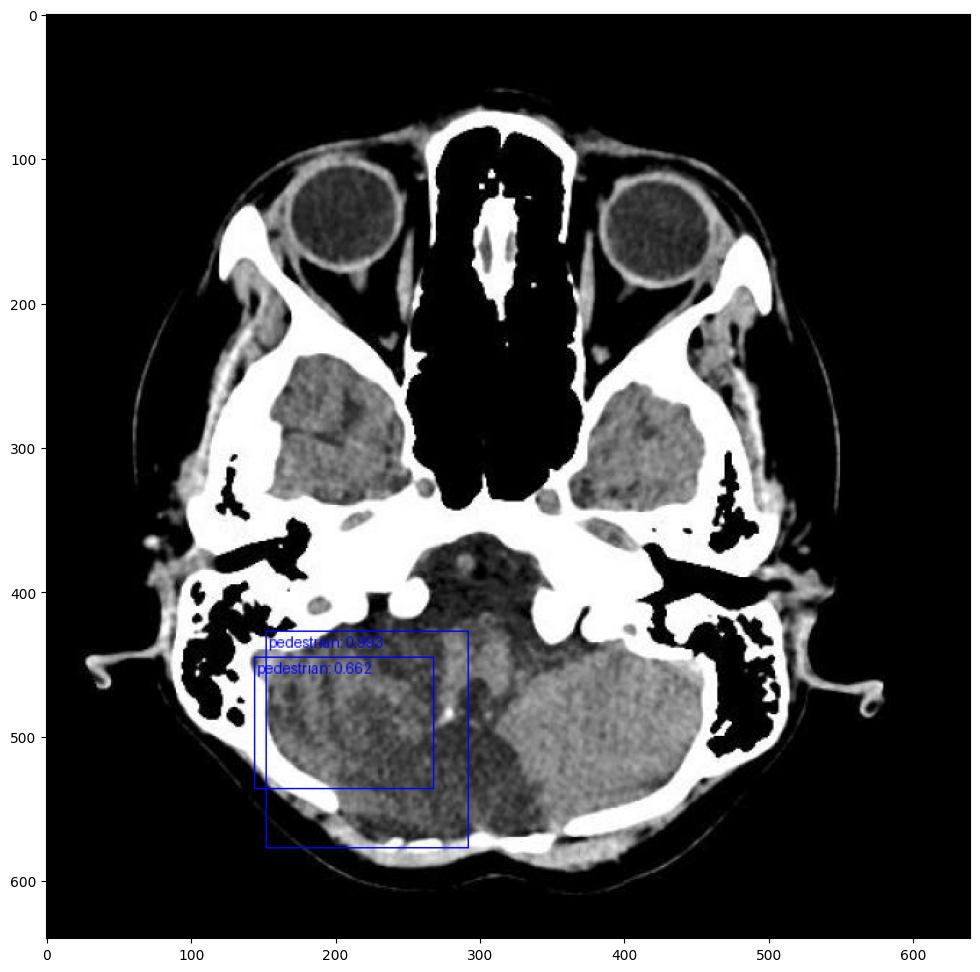

In [9]:
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="blue")

# masks = (pred["masks"] > 0.7).squeeze(1)
# output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))